In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import itertools

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

BASE_DIR = os.path.join('..')
DATA_DIR = os.path.join(BASE_DIR, 'data_final')

REG_PATH = os.path.join(DATA_DIR, 'regression_dataset_v2.csv')
MET_PATH = os.path.join(DATA_DIR, 'performance_metrics_v2.csv')

print("데이터 로드")
df_reg = pd.read_csv(REG_PATH)
df_met = pd.read_csv(MET_PATH)

print(f"회귀 데이터셋: {len(df_reg)}개")
print(f"성능 메트릭: {len(df_met)}개")

데이터 로드
회귀 데이터셋: 27298개
성능 메트릭: 2744개


In [2]:
print("\n[Step 1: 변수 정의 및 스케일링]")
print("y = a1*x1 + a2*x2 + a3*x3 + b")
print("  x1 (a1): doc_length (문서 크기)")
print("  x2 (a2): query_length (쿼리)")
print("  x3 (a3): dominant_topic (도메인)")

df_reg['doc_length_scaled'] = df_reg['doc_length'] / 1000
df_reg['query_length_scaled'] = df_reg['query_length']

print(f"\ndoc_length를 1000으로 나눔 (1k 단위)")
print(f"query_length는 그대로 사용 (형태소 개수)")


[Step 1: 변수 정의 및 스케일링]
y = a1*x1 + a2*x2 + a3*x3 + b
  x1 (a1): doc_length (문서 크기)
  x2 (a2): query_length (쿼리)
  x3 (a3): dominant_topic (도메인)

doc_length를 1000으로 나눔 (1k 단위)
query_length는 그대로 사용 (형태소 개수)


In [3]:
print("\n[Step 2: 다중공선성 진단 - 전체 변수]")
full_features = ['doc_length', 'query_length', 'query_avg_token_len',
                 'query_unique_ratio', 'query_match_count', 'query_match_ratio',
                 'dominant_topic', 'dominant_prob']

X_full = df_reg[df_reg['model'] == 'BIM'][full_features].dropna()
vif_full = pd.DataFrame()
vif_full["Feature"] = full_features
vif_full["VIF"] = [variance_inflation_factor(X_full.values, i) for i in range(len(full_features))]
vif_full = vif_full.sort_values('VIF', ascending=False)

print(vif_full.to_string(index=False))
print("\nVIF > 10: 다중공선성 심각")


[Step 2: 다중공선성 진단 - 전체 변수]
            Feature       VIF
 query_unique_ratio 56.123630
       query_length 28.299857
query_avg_token_len 28.275001
  query_match_count 24.817168
  query_match_ratio 17.497113
      dominant_prob 12.335673
     dominant_topic  3.112434
         doc_length  2.531132

VIF > 10: 다중공선성 심각


In [4]:
print("\n[Step 3: 최종 변수 선정 및 VIF 확인]")
final_features = ['doc_length_scaled', 'query_length_scaled', 'dominant_topic']

X_final = df_reg[df_reg['model'] == 'BIM'][final_features].dropna()
vif_final = pd.DataFrame()
vif_final["Feature"] = final_features
vif_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(len(final_features))]

print(vif_final.to_string(index=False))


[Step 3: 최종 변수 선정 및 VIF 확인]
            Feature      VIF
  doc_length_scaled 2.151800
query_length_scaled 2.761771
     dominant_topic 2.186296


In [8]:
print("\n[Step 4: 로지스틱 회귀 - Odds Ratio 계산]")

def run_logistic_regression(model_name, subset_df):
    X = subset_df[['doc_length_scaled', 'query_length_scaled']].copy()

    subset_df['dominant_topic'] = subset_df['dominant_topic'].astype(int)

    topics = pd.get_dummies(subset_df['dominant_topic'], prefix='topic', drop_first=True)
    X = pd.concat([X, topics], axis=1)

    y = subset_df['relevance']
    X = sm.add_constant(X)

    X = X.astype(float)
    y = y.astype(float)

    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=0, maxiter=200)

        df_res = pd.DataFrame({
            'Model': model_name,
            'Feature': result.params.index,
            'Coefficient': result.params.values,
            'Odds_Ratio': np.exp(result.params.values),
            'P_value': result.pvalues.values,
            'Lower_CI': np.exp(result.conf_int()[0].values),
            'Upper_CI': np.exp(result.conf_int()[1].values)
        })

        pseudo_r2 = result.prsquared
        aic = result.aic

        return df_res, pseudo_r2, aic
    except Exception as e:
        print(f"Error in {model_name}: {e}")
        return pd.DataFrame(), 0, 0

res_bim, r2_bim, aic_bim = run_logistic_regression("BIM", df_reg[df_reg['model'] == 'BIM'])
res_bm25, r2_bm25, aic_bm25 = run_logistic_regression("BM25", df_reg[df_reg['model'] == 'BM25_Best'])

print(f"BIM  - Pseudo R2: {r2_bim:.4f}, AIC: {aic_bim:.2f}")
print(f"BM25 - Pseudo R2: {r2_bm25:.4f}, AIC: {aic_bm25:.2f}")

odds_results = pd.concat([res_bim, res_bm25], ignore_index=True)
odds_results = odds_results[odds_results['Feature'] != 'const']

print("\n[주요 변수 Odds Ratio]")
print("\na1: doc_length_scaled")
for model in ['BIM', 'BM25']:
    row = odds_results[(odds_results['Model'] == model) &
                       (odds_results['Feature'] == 'doc_length_scaled')]
    if len(row) > 0:
        r = row.iloc[0]
        print(f"  {model}: OR={r['Odds_Ratio']:.4f}, 95%CI=[{r['Lower_CI']:.4f}, {r['Upper_CI']:.4f}], p={r['P_value']:.4f}")

print("\na2: query_length_scaled")
for model in ['BIM', 'BM25']:
    row = odds_results[(odds_results['Model'] == model) &
                       (odds_results['Feature'] == 'query_length_scaled')]
    if len(row) > 0:
        r = row.iloc[0]
        print(f"  {model}: OR={r['Odds_Ratio']:.4f}, 95%CI=[{r['Lower_CI']:.4f}, {r['Upper_CI']:.4f}], p={r['P_value']:.4f}")

print("\na3: dominant_topic (토픽별)")
topic_features = odds_results[odds_results['Feature'].str.startswith('topic_')]
for model in ['BIM', 'BM25']:
    print(f"\n  {model}:")
    model_topics = topic_features[topic_features['Model'] == model]
    for _, r in model_topics.iterrows():
        print(f"    {r['Feature']}: OR={r['Odds_Ratio']:.4f}, 95%CI=[{r['Lower_CI']:.4f}, {r['Upper_CI']:.4f}], p={r['P_value']:.4f}")


[Step 4: 로지스틱 회귀 - Odds Ratio 계산]
BIM  - Pseudo R2: 0.2344, AIC: 10295.77
BM25 - Pseudo R2: 0.0161, AIC: 15722.37

[주요 변수 Odds Ratio]

a1: doc_length_scaled
  BIM: OR=0.8949, 95%CI=[0.8899, 0.8999], p=0.0000
  BM25: OR=1.0086, 95%CI=[1.0045, 1.0128], p=0.0000

a2: query_length_scaled
  BIM: OR=1.0690, 95%CI=[1.0620, 1.0761], p=0.0000
  BM25: OR=1.0329, 95%CI=[1.0276, 1.0383], p=0.0000

a3: dominant_topic (토픽별)

  BIM:
    topic_1: OR=1.2891, 95%CI=[1.0746, 1.5462], p=0.0062
    topic_2: OR=0.9581, 95%CI=[0.7508, 1.2226], p=0.7306
    topic_3: OR=1.6637, 95%CI=[1.3485, 2.0525], p=0.0000
    topic_4: OR=1.3158, 95%CI=[1.0736, 1.6128], p=0.0082
    topic_5: OR=1.1293, 95%CI=[0.9427, 1.3528], p=0.1870
    topic_6: OR=1.6365, 95%CI=[1.3466, 1.9889], p=0.0000
    topic_7: OR=1.6256, 95%CI=[1.2462, 2.1203], p=0.0003
    topic_8: OR=1.0964, 95%CI=[0.9043, 1.3294], p=0.3491
    topic_9: OR=1.4119, 95%CI=[1.1276, 1.7678], p=0.0026

  BM25:
    topic_1: OR=1.2835, 95%CI=[1.1112, 1.4825], p=0.000

In [9]:
print("\n[Step 5: 가중치 튜닝 - Manual Linear Scoring]")
print("Score = w1*x1 + w2*x2 + w3*x3 (로지스틱 회귀 X)")

w1_candidates = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
w2_candidates = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
w3_candidates = [0.0, 0.5, 1.0, 1.5, 2.0]

print(f"w1 (doc): {w1_candidates}")
print(f"w2 (query): {w2_candidates}")
print(f"w3 (topic): {w3_candidates}")
print(f"총 조합: {len(w1_candidates)*len(w2_candidates)*len(w3_candidates)}개")

scaler = StandardScaler()
tuning_results = []

for model_type in ['BIM', 'BM25_Best']:
    print(f"\n{model_type} 가중치 탐색")

    subset = df_reg[df_reg['model'] == model_type].copy()
    y_true = subset['relevance']

    X_manual = subset[['doc_length_scaled', 'query_length_scaled', 'dominant_prob']].copy()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_manual),
        columns=X_manual.columns,
        index=subset.index
    )

    for w1, w2, w3 in tqdm(
            itertools.product(w1_candidates, w2_candidates, w3_candidates),
            total=len(w1_candidates)*len(w2_candidates)*len(w3_candidates),
            desc=model_type
    ):
        score = (w1 * X_scaled['doc_length_scaled']) + \
                (w2 * X_scaled['query_length_scaled']) + \
                (w3 * X_scaled['dominant_prob'])

        try:
            auc = roc_auc_score(y_true, score)
        except:
            auc = 0.5

        tuning_results.append({
            'model': model_type,
            'w1_doc': w1,
            'w2_query': w2,
            'w3_topic': w3,
            'AUC': auc
        })

df_tuning = pd.DataFrame(tuning_results)

print("\n[BIM 최적 가중치 Top 10]")
bim_top = df_tuning[df_tuning['model']=='BIM'].sort_values('AUC', ascending=False).head(10)
print(bim_top.to_string(index=False))

print("\n[BM25 최적 가중치 Top 10]")
bm25_top = df_tuning[df_tuning['model']=='BM25_Best'].sort_values('AUC', ascending=False).head(10)
print(bm25_top.to_string(index=False))

best_bim = bim_top.iloc[0]
best_bm25 = bm25_top.iloc[0]

print(f"\n[최적 가중치]")
print(f"BIM:  w1={best_bim['w1_doc']}, w2={best_bim['w2_query']}, w3={best_bim['w3_topic']}, AUC={best_bim['AUC']:.4f}")
print(f"BM25: w1={best_bm25['w1_doc']}, w2={best_bm25['w2_query']}, w3={best_bm25['w3_topic']}, AUC={best_bm25['AUC']:.4f}")


[Step 5: 가중치 튜닝 - Manual Linear Scoring]
Score = w1*x1 + w2*x2 + w3*x3 (로지스틱 회귀 X)
w1 (doc): [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
w2 (query): [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
w3 (topic): [0.0, 0.5, 1.0, 1.5, 2.0]
총 조합: 270개

BIM 가중치 탐색


BIM: 100%|██████████| 270/270 [00:00<00:00, 417.65it/s]



BM25_Best 가중치 탐색


BM25_Best: 100%|██████████| 270/270 [00:00<00:00, 418.46it/s]


[BIM 최적 가중치 Top 10]
model  w1_doc  w2_query  w3_topic      AUC
  BIM    -2.0       0.5       0.0 0.828619
  BIM    -2.0       0.5       0.5 0.817355
  BIM    -1.0       0.0       0.0 0.813636
  BIM    -2.0       0.0       0.0 0.813636
  BIM    -0.5       0.0       0.0 0.813636
  BIM    -1.0       0.5       0.0 0.806762
  BIM    -2.0       1.0       0.0 0.806762
  BIM    -2.0       1.0       0.5 0.803489
  BIM    -2.0       0.0       0.5 0.800551
  BIM    -2.0       0.5       1.0 0.783385

[BM25 최적 가중치 Top 10]
    model  w1_doc  w2_query  w3_topic      AUC
BM25_Best     1.0       3.0       0.0 0.579053
BM25_Best     0.5       1.5       0.0 0.579053
BM25_Best     0.5       2.0       0.0 0.578951
BM25_Best     1.5       3.0       0.0 0.578825
BM25_Best     1.0       2.0       0.0 0.578825
BM25_Best     0.5       1.0       0.0 0.578825
BM25_Best     1.0       3.0       0.5 0.578734
BM25_Best     1.5       3.0       0.5 0.578717
BM25_Best     2.0       3.0       0.5 0.578367
BM25_Best     

In [10]:
print("\n[Step 6: 성능 메트릭 집계]")
summary_metrics = []

for model in ['BIM', 'BM25_Best']:
    model_met = df_met[df_met['model'] == model]

    summary_metrics.append({
        'Model': model,
        'MAP': model_met['AP'].mean(),
        'MAP_std': model_met['AP'].std(),
        'P@10': model_met['P@10'].mean(),
        'P@10_std': model_met['P@10'].std(),
        'R@10': model_met['R@10'].mean(),
        'R@10_std': model_met['R@10'].std(),
        'Pseudo_R2': r2_bim if model == 'BIM' else r2_bm25,
        'Best_AUC': best_bim['AUC'] if model == 'BIM' else best_bm25['AUC']
    })

df_summary = pd.DataFrame(summary_metrics)
print(df_summary.to_string(index=False))


[Step 6: 성능 메트릭 집계]
    Model      MAP  MAP_std     P@10  P@10_std     R@10  R@10_std  Pseudo_R2  Best_AUC
      BIM 0.416477 0.343109 0.192638  0.189120 0.520456  0.375584   0.234355  0.828619
BM25_Best 0.630858 0.325391 0.269825  0.223543 0.681041  0.314312   0.016088  0.579053


In [11]:
print("\n[Step 7: 결과 저장]")
odds_results.to_csv(os.path.join(DATA_DIR, 'odds_ratio_v2.csv'), index=False)
df_tuning.to_csv(os.path.join(DATA_DIR, 'weight_tuning_v2.csv'), index=False)
df_summary.to_csv(os.path.join(DATA_DIR, 'summary_metrics_v2.csv'), index=False)
vif_full.to_csv(os.path.join(DATA_DIR, 'vif_full_v2.csv'), index=False)
vif_final.to_csv(os.path.join(DATA_DIR, 'vif_final_v2.csv'), index=False)


[Step 7: 결과 저장]



[Step 8: 시각화]


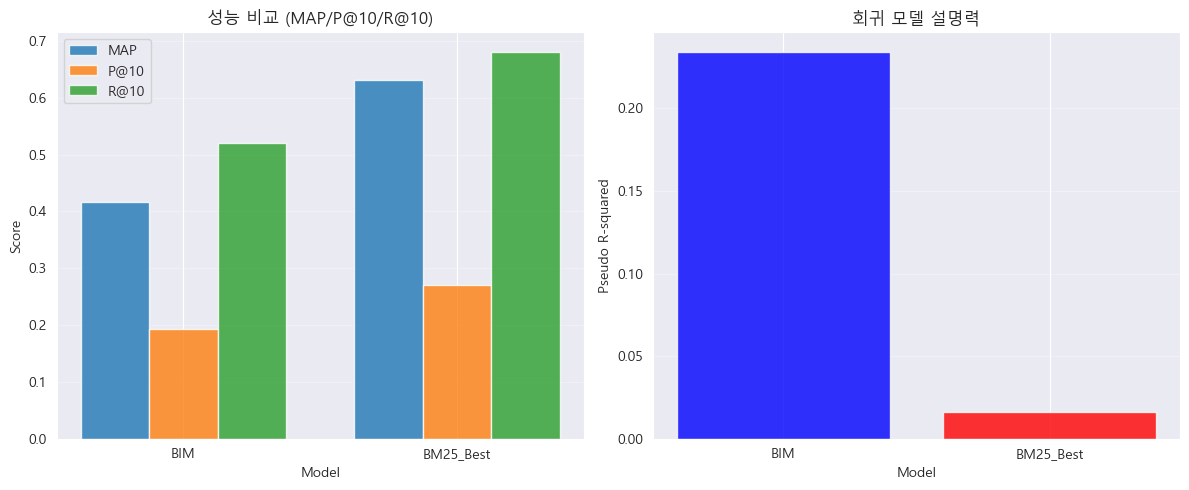

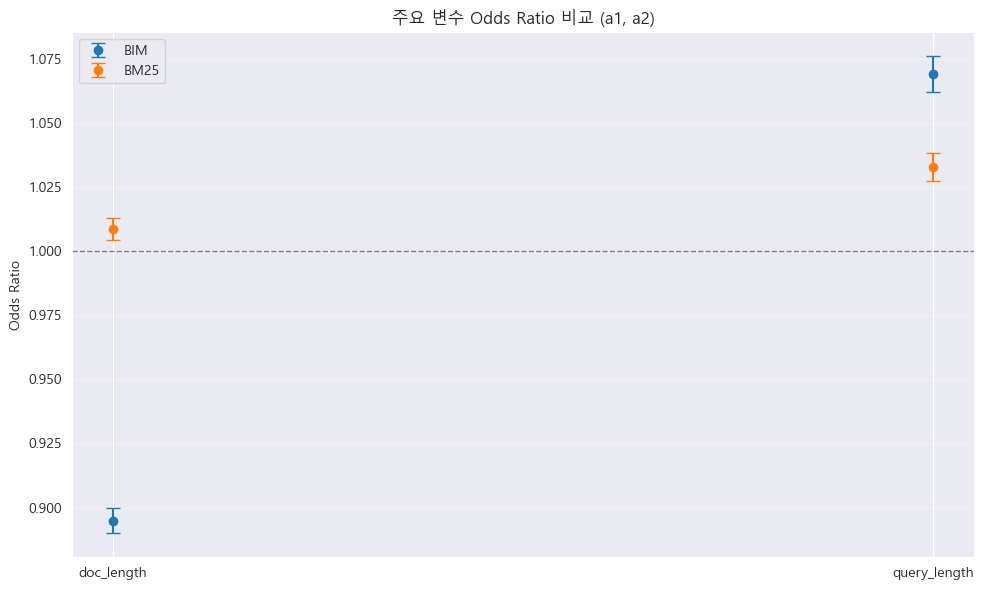

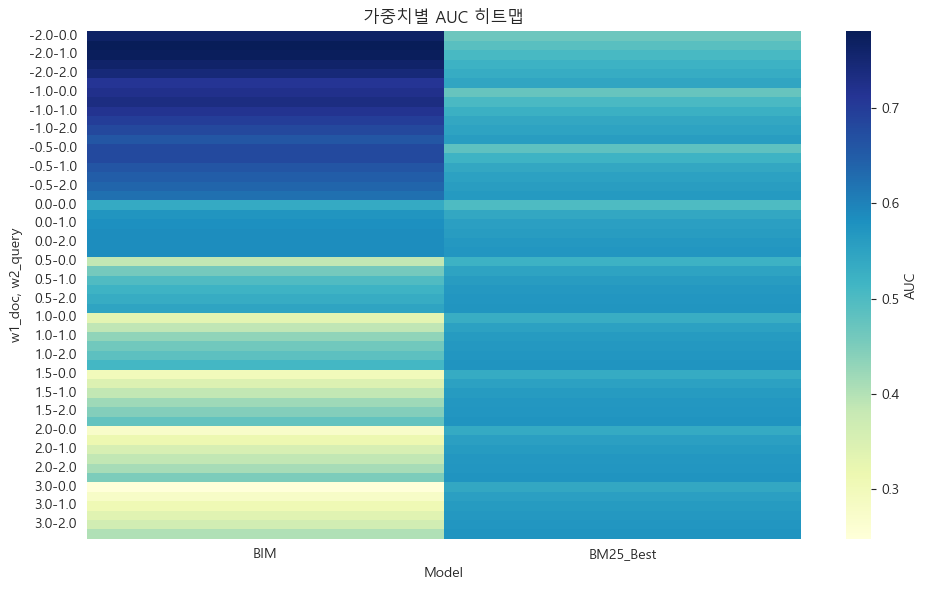


작업 완료
저장된 파일:
  - odds_ratio_v2.csv
  - weight_tuning_v2.csv
  - summary_metrics_v2.csv
  - vif_full_v2.csv / vif_final_v2.csv
  - 시각화 PNG 3개


In [12]:
print("\n[Step 8: 시각화]")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x = np.arange(len(df_summary))
width = 0.25
plt.bar(x - width, df_summary['MAP'], width, label='MAP', alpha=0.8)
plt.bar(x, df_summary['P@10'], width, label='P@10', alpha=0.8)
plt.bar(x + width, df_summary['R@10'], width, label='R@10', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('성능 비교 (MAP/P@10/R@10)')
plt.xticks(x, df_summary['Model'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(x, df_summary['Pseudo_R2'], alpha=0.8, color=['blue', 'red'])
plt.xlabel('Model')
plt.ylabel('Pseudo R-squared')
plt.title('회귀 모델 설명력')
plt.xticks(x, df_summary['Model'])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'performance_comparison_v2.png'), dpi=300)
plt.show()

main_vars = odds_results[odds_results['Feature'].isin(['doc_length_scaled', 'query_length_scaled'])]
plt.figure(figsize=(10, 6))
for model in ['BIM', 'BM25']:
    subset = main_vars[main_vars['Model'] == model]
    x_pos = np.arange(len(subset))
    plt.errorbar(x_pos, subset['Odds_Ratio'],
                 yerr=[subset['Odds_Ratio'] - subset['Lower_CI'],
                       subset['Upper_CI'] - subset['Odds_Ratio']],
                 fmt='o', label=model, capsize=5)
plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
plt.xticks(range(len(main_vars)//2), ['doc_length', 'query_length'])
plt.ylabel('Odds Ratio')
plt.title('주요 변수 Odds Ratio 비교 (a1, a2)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'odds_ratio_comparison_v2.png'), dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
pivot_auc = df_tuning.pivot_table(
    index=['w1_doc', 'w2_query'],
    columns='model',
    values='AUC',
    aggfunc='mean'
)
sns.heatmap(pivot_auc, annot=False, cmap='YlGnBu', cbar_kws={'label': 'AUC'})
plt.title('가중치별 AUC 히트맵')
plt.xlabel('Model')
plt.ylabel('w1_doc, w2_query')
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'weight_heatmap_v2.png'), dpi=300)
plt.show()

print("\n작업 완료")
print("저장된 파일:")
print("  - odds_ratio_v2.csv")
print("  - weight_tuning_v2.csv")
print("  - summary_metrics_v2.csv")
print("  - vif_full_v2.csv / vif_final_v2.csv")
print("  - 시각화 PNG 3개")